# MoA+ VS. Hinton MoE (MNIST dataset)

## 1. Setup

In [22]:
import os
import abc
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm 
from matplotlib import pyplot as plt
from sklearn.utils import shuffle
from sklearn.metrics import normalized_mutual_info_score, mean_squared_error

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPool2D, Flatten, UpSampling2D, Reshape

In [23]:
NUM_CLUSTERS = 2
EPOCHS_HINTON = 100
EPOCHS_MOA_PLUS = EPOCHS_HINTON
BATCH_SIZE = 256       
IMAGE_SHAPE = (28, 28, 1)
LEARNING_RATE = 1e-3

SEED = 21
os.environ['PYTHONHASHSEED'] = str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

## 2. Load Dataset

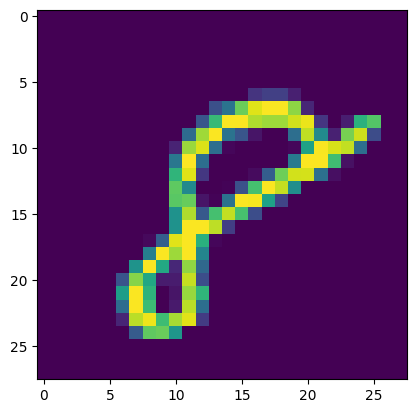

In [24]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

# filtering to get only the data with labels 0 or 1
# train_filter = np.where((y_train == 0) | (y_train == 1))
# test_filter = np.where((y_test == 0) | (y_test == 1))
# x_train, y_train = x_train[train_filter], y_train[train_filter]
# x_test, y_test = x_test[test_filter], y_test[test_filter]

x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

plt.imshow(x_train[-1])

## 3. Models

### 3.1 Hinton MoE

In [25]:
def build_expert(input_tensor):
    """ Conv Autoencoder. """
    # Encoder
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_tensor)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Flatten()(x)
    latent_space = Dense(16, activation="relu")(x)

    # Decoder
    x = Dense(4 * 4 * 8, activation="relu")(latent_space)
    x = Reshape((4, 4, 8))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = UpSampling2D((2, 2))(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="valid")(x)
    x = UpSampling2D((2, 2))(x)
    outputs = Conv2D(1, (3, 3), activation="sigmoid", padding="same")(x)

    return outputs


def build_gate(M, input_tensor):
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(input_tensor)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Conv2D(8, (3, 3), activation="relu", padding="same")(x)
    x = MaxPool2D((2, 2), padding="same")(x)
    x = Flatten()(x)
    x = Dense(M, activation='softmax')(x)

    return x

class MixtureOfExperts(tf.keras.Model):
    def __init__(self, input_dim, num_clusters):
        super().__init__()
        self.input_dim = input_dim
        self.num_experts = num_clusters  # suggestion that #clusters == #experts

        self.experts = [self.build_expert() for _ in range(self.num_experts)]
        self.gate = self.build_gate()

    def call(self, inputs):
        expert_outputs = [expert(inputs) for expert in self.experts]  # (batch_size, H, W, C)
        # print("Expert outputs shape:", expert_outputs[0].shape)
        gate_output = self.gate(inputs)  # (batch_size, num_experts)
        # print("Gate output shape:", gate_output.shape)
        weighted_expert_outputs = [
            tf.multiply(
                expert_output,
                tf.expand_dims(tf.expand_dims(tf.expand_dims(gate_output[:, i], axis=1), axis=1), axis=1)
                # (batch_size, 1, 1, 1)
            )
            for i, expert_output in enumerate(expert_outputs)
        ]
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=0)
        return aggregated_output

    def build_expert(self):
        """ Conv Autoencoder. """
        # Encoder
        inputs = Input(shape=self.input_dim)
        outputs = build_expert(inputs)
        # Autoencoder
        model = tf.keras.Model(inputs=inputs, outputs=outputs)
        return model

    def build_gate(self):
        inputs = Input(shape=self.input_dim)
        gate = build_gate(self.num_experts, inputs)
        model = tf.keras.Model(inputs=inputs, outputs=gate)
        return model

    def get_expert_outputs(self, x):
        return [expert(x) for expert in self.experts]

    def get_cluster_assignments(self, x):
        gating_weights = self.gate(x)
        return tf.argmax(gating_weights, axis=1)


hinton_model = MixtureOfExperts(IMAGE_SHAPE, NUM_CLUSTERS)
hinton_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss='mse') 
hinton_model.summary() 

print(f"Training Hinton model for {EPOCHS_HINTON} epochs...")
hinton_history = hinton_model.fit(
    x_train, x_train, 
    epochs=EPOCHS_HINTON,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    verbose=1 # Show progress
)

Model: "mixture_of_experts_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ functional_9 (Functional)            │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_10 (Functional)           │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ functional_11 (Functional)           │ (None, 2)                   │           1,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,076 (62.80 KB)

 Trainable params: 16,076 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

Training Hinton model for 100 epochs...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 18s 26ms/step - loss: 0.1166 - val_loss: 0.0488
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0443 - val_loss: 0.0348
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0337 - val_loss: 0.0295
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0292 - val_loss: 0.0270
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0269 - val_loss: 0.0254
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0255 - val_loss: 0.0243
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0244 - val_loss: 0.0235
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0236 - val_loss: 0.0228
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0229 - val_loss: 0.0221
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 0.0223 - val_loss: 0.0216
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.0219 - val_loss: 0.0212

### 3.2 MoA+

In [26]:
class MoA_plus(tf.keras.Model):
    def __init__(self, input_dim, num_clusters, **kwargs):
        super().__init__(**kwargs)
        self.input_dim = input_dim
        self.num_experts = num_clusters # suggestion that #clusters == #experts

        self.experts = [self.build_expert(k) for k in range(self.num_experts)]
        self.gate = self.build_gate()

        # Trainable variable for the 1/lambda_k^2 terms.
        # Initialize to ones. Using relu ensures non-negativity.
        # Add a small epsilon for numerical stability if needed.
        self.inv_lambda_sq_raw = self.add_weight(
            name='inv_lambda_sq_raw',
            shape=(self.num_experts,),
            initializer='ones',
            trainable=True
        )

    @property
    def inv_lambda_sq(self):
        return tf.nn.relu(self.inv_lambda_sq_raw) + tf.keras.backend.epsilon()


    def call(self, inputs, training=False):
        expert_outputs = [expert(inputs, training=training) for expert in self.experts]
        gate_output = self.gate(inputs, training=training)

        gate_output_reshaped = tf.reshape(gate_output, [-1, 1, 1, 1, self.num_experts])
        expert_outputs_stacked = tf.stack(expert_outputs, axis=-1)
        weighted_expert_outputs = expert_outputs_stacked * gate_output_reshaped
        aggregated_output = tf.reduce_sum(weighted_expert_outputs, axis=-1)
        return aggregated_output

    def build_expert(self, expert_index):
        """ Builds a single expert model. """
        inputs = Input(shape=self.input_dim)
        outputs = build_expert(inputs)
        model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f'expert_{expert_index}')
        return model

    def build_gate(self):
        """ Builds the gating model. """
        inputs = Input(shape=self.input_dim)
        gate_outputs = build_gate(self.num_experts, inputs)
        model = tf.keras.Model(inputs=inputs, outputs=gate_outputs, name='gate')
        return model

    def train_step(self, data):
        if isinstance(data, tuple):
            x, y_true = data
        else:
            x = data
            y_true = x

        with tf.GradientTape() as tape:
            expert_outputs = [expert(x, training=True) for expert in self.experts]
            gate_output = self.gate(x, training=True) # These are p_{i:n}^k

            # L = term1 * term2
            # term1 = sqrt( sum_k (1 / lambda_k^2) )
            # term2 = sqrt( sum_k [ (sum_i p_ik * (X_i - Xhat_ik)^2) ]^2 )

            # Calculate term1
            term1 = tf.sqrt(tf.reduce_sum(self.inv_lambda_sq))

            # Calculate term2
            inner_sum_sq_terms = []
            for k in range(self.num_experts):
                x_hat_k = expert_outputs[k]
                p_k = gate_output[:, k]

                # Calculate pixel-wise squared error: (X_i - Xhat_ik)^2
                pixel_sq_error = tf.square(y_true - x_hat_k)
                sample_sq_error = tf.reduce_sum(pixel_sq_error, axis=[1, 2, 3])
                weighted_sum_k = tf.reduce_sum(p_k * sample_sq_error) # Scalar
                inner_sum_sq_terms.append(tf.square(weighted_sum_k))

            sum_inner_sq = tf.reduce_sum(tf.stack(inner_sum_sq_terms))
            term2 = tf.sqrt(sum_inner_sq + tf.keras.backend.epsilon()) # Add epsilon for stability

            # Calculate L
            loss = term1 * term2

        trainable_vars = self.trainable_variables
        gradients = tape.gradient(loss, trainable_vars)

        self.optimizer.apply_gradients(zip(gradients, trainable_vars))
        results = {"loss": loss}
        return results

    def get_expert_outputs(self, x):
        return [expert(x, training=False) for expert in self.experts]

    def get_gate_probabilities(self, x):
         return self.gate(x, training=False)

    def get_cluster_assignments(self, x):
        gating_weights = self.get_gate_probabilities(x)
        return tf.argmax(gating_weights, axis=1)

moa_plus_model = MoA_plus(IMAGE_SHAPE, NUM_CLUSTERS)
moa_plus_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),loss='mse') 
moa_plus_model.summary() 

print(f"Training MoA_plus model for {EPOCHS_MOA_PLUS} epochs...")
moa_plus_model_history = moa_plus_model.fit(
    x_train, x_train, 
    epochs=EPOCHS_MOA_PLUS,
    batch_size=BATCH_SIZE,
    validation_data=(x_test, x_test),
    verbose=1
)

Model: "mo_a_plus_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ expert_0 (Functional)                │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ expert_1 (Functional)                │ (None, 28, 28, 1)           │           7,313 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gate (Functional)                    │ (None, 2)                   │           1,450 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,078 (62.80 KB)

 Trainable params: 16,078 (62.80 KB)

 Non-trainable params: 0 (0.00 B)

Training MoA_plus model for 100 epochs...
Epoch 1/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 17s 26ms/step - loss: 16039.9072 - val_loss: 0.0531
Epoch 2/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 7819.9595 - val_loss: 0.0372
Epoch 3/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 5352.0649 - val_loss: 0.0312
Epoch 4/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 4013.7241 - val_loss: 0.0284
Epoch 5/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 2703.9783 - val_loss: 0.0268
Epoch 6/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 318.0251 - val_loss: 0.0264
Epoch 7/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7094 - val_loss: 0.0263
Epoch 8/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7070 - val_loss: 0.0263
Epoch 9/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7062 - val_loss: 0.0263
Epoch 10/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.7056 - val_loss: 0.0263
Epoch 11/100
235/235 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - loss: 1.705

## 4. Evaluate Models


 Evaluating Model: Hinton MoE 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

 Final Validation MSE (from history): 0.015678
NMI: 0.0087


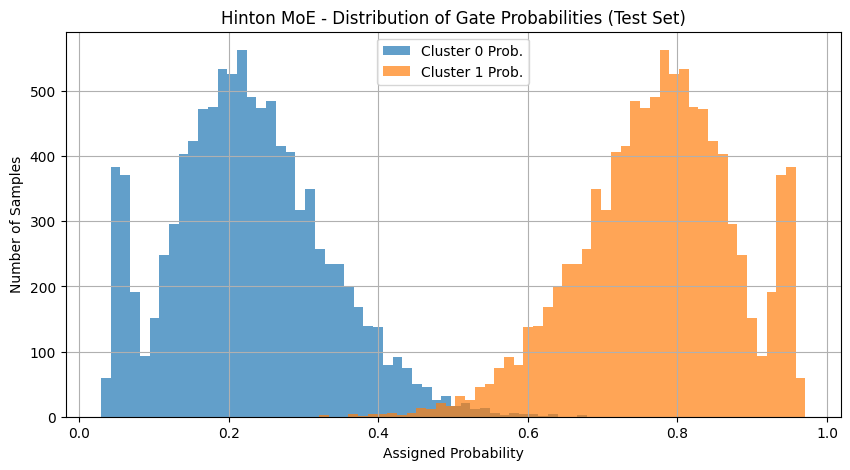

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


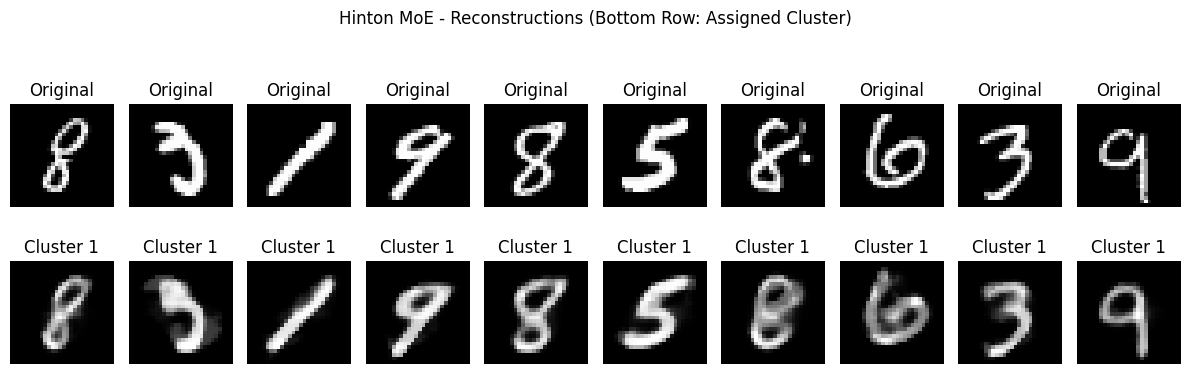

Percentage of True Labels within each Predicted Cluster for Hinton MoE:


,Cluster 0,Cluster 1
TrueLabel,,
0,0.00,9.89
1,0.00,11.45
2,9.20,10.33
3,14.94,10.06
4,0.00,9.91
5,59.77,8.47
6,12.64,9.55
7,1.15,10.36
8,2.30,9.81





 Evaluating Model: MoA+ 

40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step

 Final Validation MSE (from history): 0.017871
NMI: 0.2988


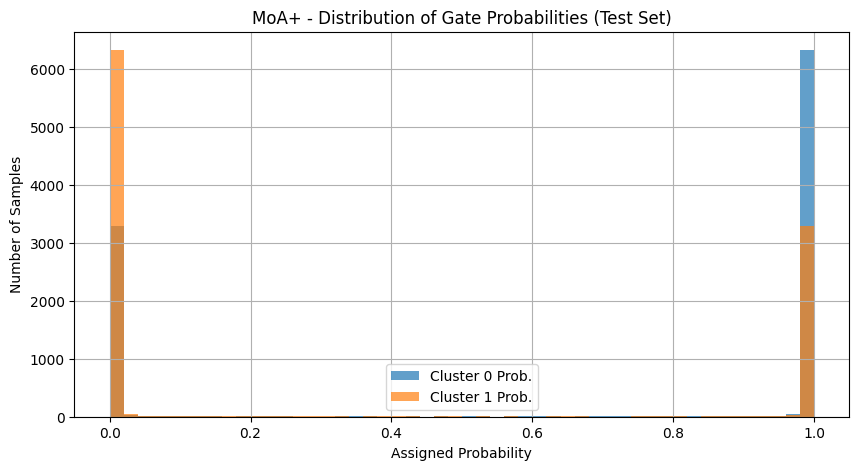

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


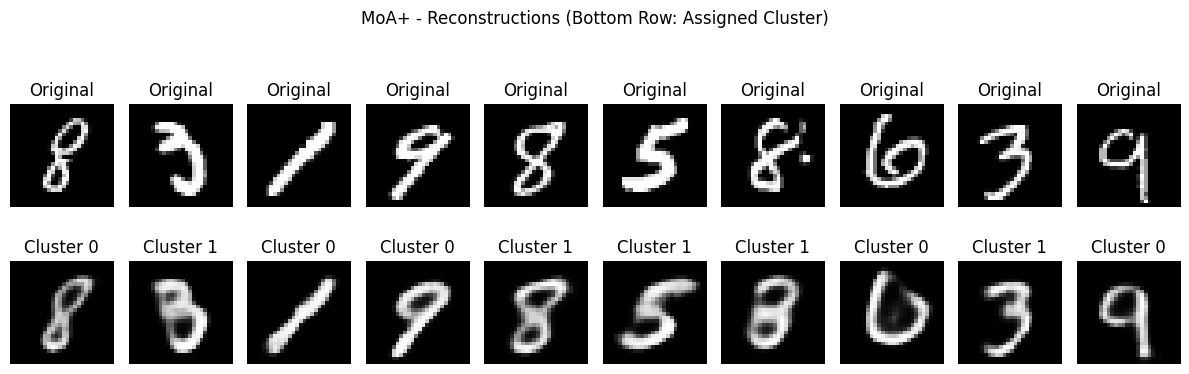

Percentage of True Labels within each Predicted Cluster for MoA+:


,Cluster 0,Cluster 1
TrueLabel,,
0,14.85,0.20
1,17.13,0.35
2,0.27,29.43
3,0.09,29.14
4,14.89,0.17
5,3.13,19.94
6,14.34,0.52
7,13.95,3.31
8,6.58,15.76


In [27]:
models_dict = {
    "Hinton MoE": (hinton_model, hinton_history),
    "MoA+": (moa_plus_model, moa_plus_model_history)
}

n_images_to_show = 10
indices_to_show = np.random.choice(x_test.shape[0], n_images_to_show, replace=False)
x_test_sample = x_test[indices_to_show]

for model_name, (model, history) in models_dict.items():
    print(f"\n Evaluating Model: {model_name} \n")

    all_assignments = model.get_cluster_assignments(x_test).numpy()
    gate_probs_test = model.gate.predict(x_test, batch_size=BATCH_SIZE)
    if isinstance(gate_probs_test, tf.Tensor):
        gate_probs_test = gate_probs_test.numpy()

    final_val_mse = history.history['val_loss'][-1]
    print(f"\n Final Validation MSE (from history): {final_val_mse:.6f}")
    nmi_score = normalized_mutual_info_score(y_test, all_assignments)
    print(f"NMI: {nmi_score:.4f}")


    plt.figure(figsize=(10, 5))
    for k in range(NUM_CLUSTERS):
        plt.hist(gate_probs_test[:, k], bins=50, alpha=0.7, label=f'Cluster {k} Prob.')
    plt.title(f'{model_name} - Distribution of Gate Probabilities (Test Set)')
    plt.xlabel('Assigned Probability')
    plt.ylabel('Number of Samples')
    plt.legend()
    plt.grid(True)
    plt.show()
  



    reconstructions_sample = model.predict(x_test_sample, batch_size=BATCH_SIZE)
    assignments_sample = all_assignments[indices_to_show] # Use assignments already calculated

    plt.figure(figsize=(12, 4))
    for i in range(n_images_to_show):
        ax = plt.subplot(2, n_images_to_show, i + 1)
        plt.imshow(x_test_sample[i].reshape(28, 28), cmap='gray')
        plt.title(f"Original")
        plt.axis('off')
        ax = plt.subplot(2, n_images_to_show, i + 1 + n_images_to_show)
        plt.imshow(reconstructions_sample[i].reshape(28, 28), cmap='gray')
        plt.title(f"Cluster {assignments_sample[i]}") # Caption with assigned cluster
        plt.axis('off')
    plt.suptitle(f'{model_name} - Reconstructions (Bottom Row: Assigned Cluster)', y=1.02)
    plt.tight_layout()
    plt.show()

    df_clusters = pd.DataFrame({'TrueLabel': y_test, 'PredictedCluster': all_assignments})
    ct = pd.crosstab(df_clusters['TrueLabel'], df_clusters['PredictedCluster'])
    ct_percent = ct.apply(lambda x: x / x.sum() * 100, axis=0)

    ct_percent = ct_percent.round(2)
    ct_percent.columns = [f'Cluster {col}' for col in ct_percent.columns]

    print(f"Percentage of True Labels within each Predicted Cluster for {model_name}:")
    display(ct_percent)


    print("\n" + "="*50 + "\n")